In [1]:
# TODO: add text and explanation to this notebook

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable

import os,sys,inspect
sys.path.insert(0, "..")

from src.model import GMM

(-1.2029644571182405,
 1.2065755449173126,
 -1.207386525496859,
 1.2108792384714073)

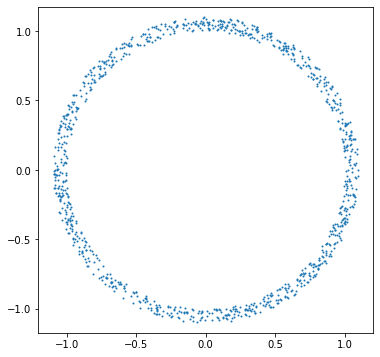

In [3]:
def generate_samples(n):
    r = 1+torch.rand(n,1)*0.1
    theta = 2*3.1415926*torch.rand(n,1)
    x = torch.cos(theta)*r
    y = torch.sin(theta)*r
    return x, y

n = 1000
x, y = generate_samples(n)
plt.figure(figsize=[6,6])
plt.scatter(x.tolist(), y.tolist(),1)
plt.axis('equal')

In [4]:
import math
class GaussianMixture(nn.Module):
    def __init__(self):
        super(GaussianMixture, self).__init__()
        
        # Simple Neural Network to model the parameters of the GMM:
        #   Input: shape (1,1)
        #   Output: shape (1,72) -> 24 components
        self.main = nn.Sequential(nn.Linear(1,4),
                                  nn.ReLU(),
                                  nn.Linear(4,8),
                                  nn.ReLU(),
                                  nn.Linear(8,16),
                                  nn.ReLU(),
                                  nn.Linear(16,18),
                                  nn.ReLU(),
                                  nn.Linear(18,36),
                                  nn.ReLU(),
                                  nn.Linear(36,72))
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax()
    
    def forward(self, input):
        """
        Calculate the parameters of a GMM with 24 components
        """       
        output = self.main(input)
        mu, sigma, pi = output[:,:24], output[:,24:48], output[:,48:]
        print("--- Forward ---")
        print("Input shape: ", input.shape)
        print("Output shape: ", output.shape)
        print("Mu shape: ", mu.shape)
        print("Sigma shape: ", sigma.shape)
        print("Pi shape: ", pi.shape)
        print()
        return mu, sigma, pi
    
    def logits(self, x, y):
        """
        Calculate the loss of the GMM w.r.t the data y.
        """
        mu, sigma, pi = self.forward(x)
        loss = GMM.loss_gmm(mu, sigma, pi, y)
        print("--- Logits ---")
        print("x shape: ", x.shape)
        print("y shape: ", y.shape)
        print("Mu shape: ", mu.shape)
        print("Sigma shape: ", sigma.shape)
        print("Pi shape: ", pi.shape)
        print("Loss shape: ", loss.shape)
        print()
        return loss
    
    def generate(self, x):
        """
        Generate samples from the GMM with the parameters calculated
        by the Neural Network
        """
        mu, sigma, pi = self.forward(x)
        sample = GMM.sample_gmm(mu, sigma, pi)
        print("--- Generate ---")
        print("x shape: ", x.shape)
        print("Mu shape: ", mu.shape)
        print("Sigma shape: ", sigma.shape)
        print("Pi shape: ", pi.shape)
        print("sample shape: ", sample.shape)
        print()
        return sample

In MelNet, every $x_{ij}$ is modelled as a Gaussian Mixture Model with K components. 
Every $\theta_{ij}$ consists of 3K parameters.

The negative log-likelihood of every pixel ($x_{ij}$) would be: $- log L(\theta | x_{ij}) = - log p_\theta(x_{ij}) = - log \prod_{1}^{1} \sum_{k=1}^{K} \pi_k N(x_{ij}; mu_{ijk}, std_{ijk})$

The negative log-likelihood of all the pixels would be: $\sum_{pixel=1}^{i*j} - log L(\theta | x_{ij}) = \sum_{pixel=1}^{i*j} - log p_\theta(x_{ij}) = \sum_{pixel=1}^{i*j} - log \prod_{1}^{1} \sum_{k=1}^{K} \pi_k N(x_{ij}; mu_{ijk}, std_{ijk})$



Which is equal to: $- log L(\theta | x_{ij}) = - log p_\theta(x_{ij}) = - \sum log \sum \pi_k N(x_{ij}; mu_{ijk}, std_{ijk})$



Using the log sum exp trick: $- log L(\theta | x_{ij}) = - log p_\theta(x_{ij}) = - \sum log \sum exp(log(\pi_k) + log( N(x_{ij}; mu_{ijk}, std_{ijk}))$

$\sum - log L(\theta | x_{ij}) = \sum - log p_\theta(x_{ij}) = \sum - \sum log \sum exp(log(\pi_k) + log( N(x_{ij}; mu_{ijk}, std_{ijk}))$

--- Forward ---
Input shape:  torch.Size([300, 1])
Output shape:  torch.Size([300, 72])
Mu shape:  torch.Size([300, 24])
Sigma shape:  torch.Size([300, 24])
Pi shape:  torch.Size([300, 24])

--- Generate ---
x shape:  torch.Size([300, 1])
Mu shape:  torch.Size([300, 24])
Sigma shape:  torch.Size([300, 24])
Pi shape:  torch.Size([300, 24])
sample shape:  torch.Size([300, 1])



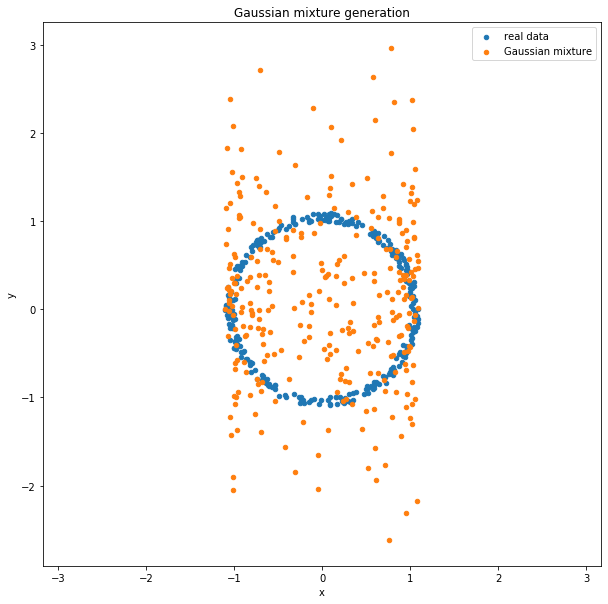

In [5]:
import numpy as np

net = GaussianMixture()
def plot_generated_samples(n=300):
    x,y = generate_samples(n)
    y_gen = net.generate(Variable(x))

    fig = plt.figure(figsize=[10,10])
    plt.scatter(x.tolist(), y.tolist(), 20)
    plt.scatter(x.tolist(), y_gen.data.tolist(),20)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    #plt.figure(figsize=[6,6])
    plt.legend(['real data','Gaussian mixture'])
    plt.title('Gaussian mixture generation')
    
plot_generated_samples();

In [6]:
net = GaussianMixture()

loss_save = []
batch_size = 200
max_epoch = 1500
optimizer = optim.Adam(net.parameters(), lr = 0.01)
m = nn.LogSoftmax()

for epoch in range(max_epoch):
    optimizer.zero_grad()
    x, y = generate_samples(batch_size)
    loss = net.logits(Variable(x),Variable(y))
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print("epoch {}, loss {}".format(epoch, loss.item()))
    loss_save.append(loss.item())

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

epoch 0, loss 246.93319702148438
--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  t

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

epoch 100, loss 180.97303771972656
--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape: 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forwa

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits 

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size([])

--- Forward ---
Input shape:  torch.Size([200, 1])
Output shape:  torch.Size([200, 72])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])

--- Logits ---
x shape:  torch.Size([200, 1])
y shape:  torch.Size([200, 1])
Mu shape:  torch.Size([200, 24])
Sigma shape:  torch.Size([200, 24])
Pi shape:  torch.Size([200, 24])
Loss shape:  torch.Size

Final loss: -192.8358154296875


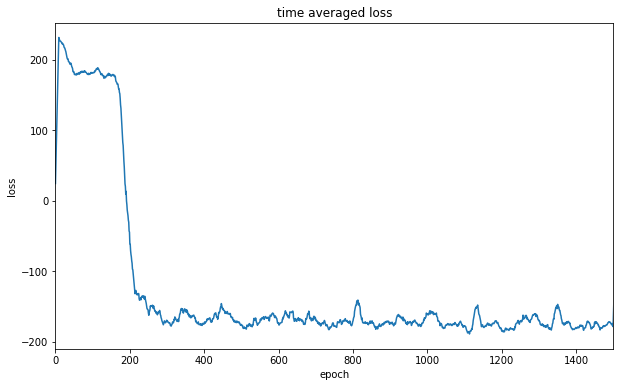

In [7]:
plt.figure(figsize=[10,6])
plt.plot(np.convolve(loss_save, np.ones(10)/10))
plt.xlim([0,max_epoch])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('time averaged loss')
print("Final loss:", loss_save[-1])

--- Forward ---
Input shape:  torch.Size([300, 1])
Output shape:  torch.Size([300, 72])
Mu shape:  torch.Size([300, 24])
Sigma shape:  torch.Size([300, 24])
Pi shape:  torch.Size([300, 24])

--- Generate ---
x shape:  torch.Size([300, 1])
Mu shape:  torch.Size([300, 24])
Sigma shape:  torch.Size([300, 24])
Pi shape:  torch.Size([300, 24])
sample shape:  torch.Size([300, 1])



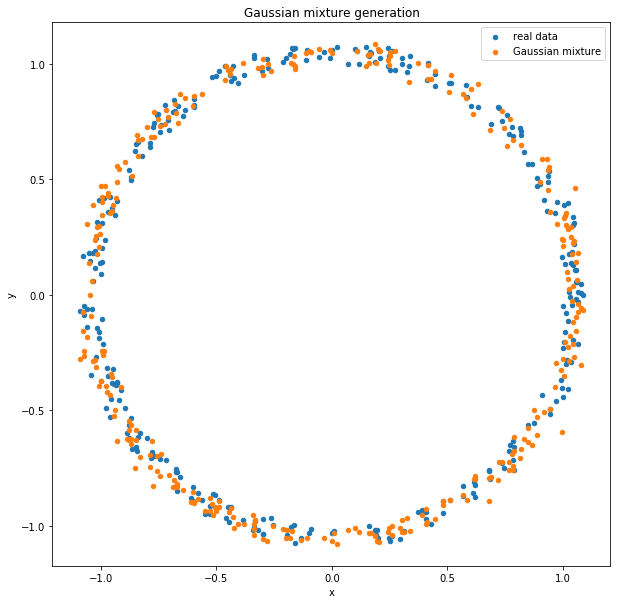

In [8]:
plot_generated_samples()

When explaining everything, make special attention to show how important is to normalize data because when data is close to 0, results are way better